Traceback (most recent call last):
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/Users/taneemishere/miniforge3/envs/pto/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/taneemishere/miniforge3/envs/pto/lib/

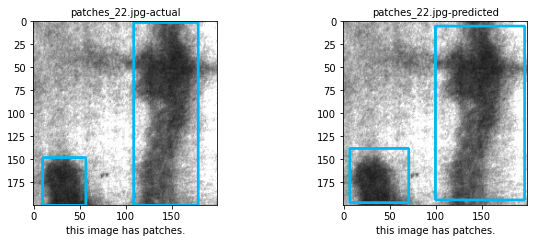

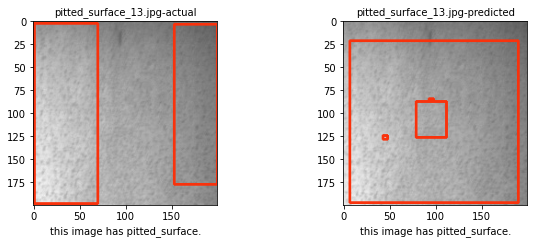

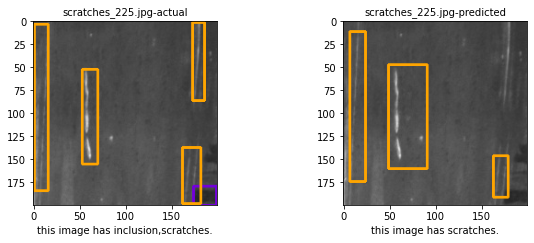

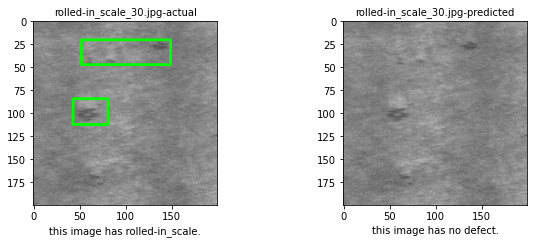

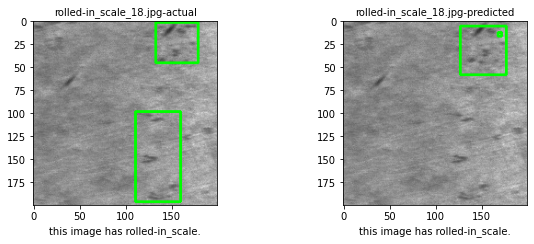

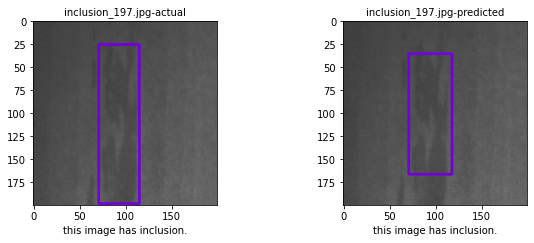

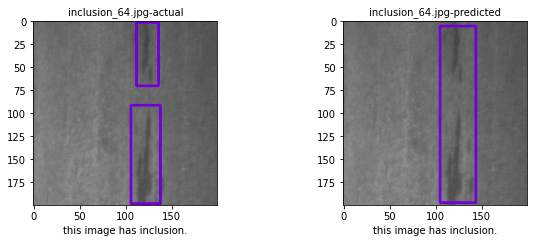

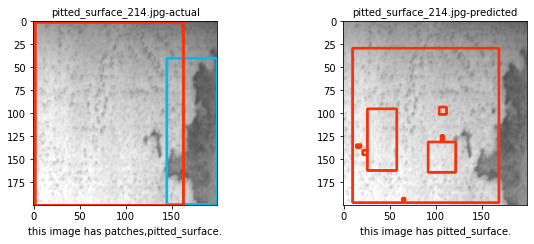

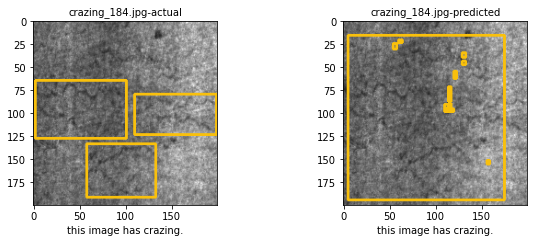

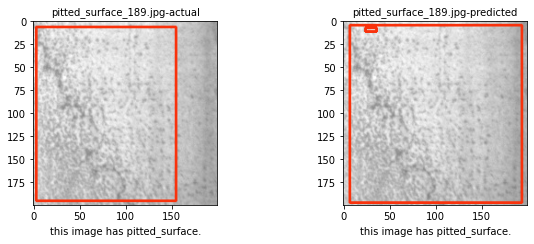

KeyboardInterrupt: 

In [34]:
import os
import cv2
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from utils.Extract_masks import make_mask, create_filepaths
from utils.Data_Retriever_Inference_Real_Time import TestDataset

warnings.filterwarnings("ignore")


def load_model(device, model_path, model):
    model.to(device)
    model.eval()
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    new_state_dict = OrderedDict()
    for k, v in state["state_dict"].items():
        name = k[7:]
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    return model


def post_process(probability, threshold, min_size):
    mask = (probability > threshold).astype(np.uint8)
    num_component, component = cv2.connectedComponents(mask)
    predictions = np.zeros_like(mask, dtype=np.float32)
    num = 0

    for c in range(1, num_component):
        region = (component == c)
        if region.sum() > min_size:
            predictions[region] = 1
            num += 1

    return predictions, num


def mask2rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def get_prediction(testset, model, device, best_threshold, min_size):
    predictions = []

    for fnames, images in testset:
        batch_preds = torch.sigmoid(model(images.to(device))).detach().cpu().numpy()

        for fname, preds in zip(fnames, batch_preds):
            for cls, pred in enumerate(preds):
                pred, num = post_process(pred, best_threshold, min_size)
                # rle = mask2rle(pred)
                pixel = pred.T.flatten()
                pixel = np.concatenate([[0], pixel, [0]])
                runs = np.where(pixel[1:] != pixel[:-1])[0] + 1
                runs[1::2] -= runs[::2]
                rectangle = ' '.join(str(x) for x in runs)
                name = f"{fname}*{cls + 1}"
                predictions.append([name, rectangle])

    return predictions


def name_and_mask(ls):
    img_names = [str(ele[0]).split("*")[0] for ele in ls]

    if not all(name == img_names[0] for name in img_names):
        raise ValueError

    labels = [ele[1] for ele in ls]
    mask = np.zeros((128, 128, 6), dtype=np.uint8)

    for idx, label in enumerate(labels):
        if label != '':
            mask_label = np.zeros(128 * 128, dtype=np.uint8)
            positions = map(int, label.split()[0::2])
            lengths = map(int, label.split()[1::2])

            for pos, le in zip(positions, lengths):
                mask_label[pos - 1:pos + le - 1] = 1

            mask[:, :, idx] = mask_label.reshape(128, 128, order='F')

    return img_names[0], mask


def generate_contours(image_folder, name, mask_type, mask, defects, palet):
    img = cv2.imread(os.path.join(image_folder, name))
    str1 = "this image has"
    str2 = "no defect"
    multi = 0

    for ch in range(6):
        mask_channel = mask[:, :, ch] if mask_type == 'actual' else cv2.resize(
            mask[:, :, ch], (200, 200), interpolation=cv2.INTER_NEAREST
        )
        contours, _ = cv2.findContours(mask_channel, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.boundingRect(cnt) for cnt in contours]

        if len(contours) > 0:
            multi += 1
            if multi > 1:
                str2 = f"{str2},{defects[ch]}"
            else:
                str2 = defects[ch]
        for x, y, w, h in contours:
            cv2.rectangle(img, (x, y), (x + w, y + h), palet[ch], 2)

    str3 = f"{str1} {str2}."
    return img, str3


def show_mask_image(col, annot_folder, image_folder, labels, defects, palet):
    name, predicted_mask = name_and_mask(col)
    annot = os.path.join(annot_folder, f"{name[:-4]}.xml")

    fig, ax = plt.subplots(1, 2, figsize=(10, 10), tight_layout={'pad': 10.0})

    for i, mask_type in enumerate(['actual', 'predicted']):
        mask = make_mask(annot, labels) if mask_type == 'actual' else predicted_mask
        image, str3 = generate_contours(image_folder, name, mask_type, mask, defects, palet)

        ax[i].set_title(f"{name}-{mask_type}", fontsize=10)
        ax[i].set_xlabel(str3, fontsize=10)
        ax[i].imshow(image)

    plt.show()


def inference():
    test_image_folder = "./Validation_Images"
    test_annot_folder = "./Validation_Annotations"
    model_path = "./weights/defect_segmentation.pth"
    model = smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        classes=6,
        activation=None,
    )
    defects = ["crazing", "patches", "inclusion", "pitted_surface", "rolled-in_scale", "scratches"]
    palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249, 50, 12), (0, 255, 0), (255, 165, 0)]

    df = create_filepaths(test_annot_folder)
    for idx in df.index:
        fname = df.iloc[idx][0] + '.jpg'
        labels = df.iloc[idx][1:7].to_dict()

        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        validation_set = DataLoader(
            TestDataset(test_image_folder, fname, mean, std),
            batch_size=1,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        device = torch.device("cpu")
        model = load_model(device, model_path, model)
        predictions = get_prediction(validation_set, model, device, 0.5, 200)
        show_mask_image(predictions, test_annot_folder, test_image_folder, labels, defects, palet)


if __name__ == "__main__":
    inference()
